# ISC

    python code/clean.py
    sbatch --mem=64G --time=00:60:00 code/slurm.sh code/groupavg.py

In [1]:
import h5py
import numpy as np
import pandas as pd
from tqdm import tqdm
from util import plot
import matplotlib.pyplot as plt
from himalaya.scoring import correlation_score
from scipy.stats import pearsonr

from util.path import Path

from constants import SUBS

In [2]:
%cd ..

/mnt/cup/labs/hasson/zaid/narrative-enc


/usr/people/zzada/.conda/envs/fconv2/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
narrative = 'black'

# ISC by leave-one-out vs group-average

In [8]:
scores = []
for sub in tqdm(SUBS[narrative]):

    subpath = Path(
        root="derivatives/clean",
        datatype="func",
        sub=f"{sub:03d}",
        task=narrative,
        space="fsaverage6",
        ext=".h5",
    )

    grouppath = Path(
        root="derivatives/leaveout",
        datatype="func",
        sub=f"{sub:03d}",
        task=narrative,
        space="fsaverage6",
        ext=".h5",
    )

    with h5py.File(subpath, "r") as f:
        boldS = f["bold"][...]

    with h5py.File(grouppath, "r") as f:
        boldO = f["bold"][...]

    scores.append(correlation_score(boldS, boldO))

100%|██████████| 46/46 [02:56<00:00,  3.85s/it]


In [9]:
scores = np.stack(scores)
scores.shape

(46, 81924)

In [11]:
avg_scores = scores.mean(0)

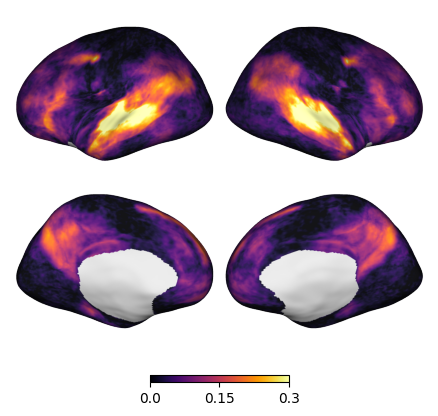

In [14]:
fig = plot.surface_plot(avg_scores, vmin=0, vmax=0.3, cmap='inferno')
fig.show()

## load scores

In [39]:
# get scores
df = pd.read_csv('data/participants.tsv', sep='\t')
df['task'] = df.task.str.split(',')
df['comprehension'] = df.comprehension.str.split(',')
df['participant_id'] = df.participant_id.apply(lambda x: int(x.split('-')[1]))
df.head()

,participant_id,age,sex,task,condition,comprehension
0,1,"22,23","F,F","[pieman, tunnel]","n/a,n/a","[n/a, n/a]"
1,2,20,M,[pieman],NaN,NaN
2,3,NaN,F,[pieman],NaN,NaN
3,4,"24,24","M,M","[pieman, tunnel]","n/a,n/a","[n/a, n/a]"
4,5,"n/a,n/a","M,M","[pieman, tunnel]","n/a,n/a","[n/a, n/a]"


In [47]:
df2 = df.explode(['task', 'comprehension'])
df2['comprehension'] = df2.comprehension.str.replace('n/a', 'nan')
df2['comprehension'] = df2.comprehension.apply(float)
df3 = df2[df2.task == 'black']
df3.set_index('participant_id', inplace=True)
df3.head()

,age,sex,task,condition,comprehension
participant_id,,,,,
127,"31,30,30,32,32,32,32","F,F,F,F,F,F,F",black,"synonyms,movie-physical-social,movie-physical-...",0.76
265,"19,20,20,20,20","F,F,F,F,F",black,"n/a,n/a,n/a,n/a,n/a",0.76
267,"26,27,27,27,27","F,F,F,F,F",black,"n/a,n/a,n/a,n/a,n/a",0.88
272,"19,19,19,19","F,F,F,F",black,"n/a,n/a,n/a,n/a",0.64
273,"20,20,20,20","M,M,M,M",black,"n/a,n/a,n/a,n/a",0.96


In [51]:
comp_scores = df3.loc[SUBS[narrative]]['comprehension'].to_numpy()
len(comp_scores)

46

In [57]:
pearsonr(comp_scores, np.median(scores, 1))

PearsonRResult(statistic=0.5586859802552582, pvalue=5.4560995921119695e-05)

# ISC by pariwise subjects

In [8]:
# this is too inefficient. probably should do it similar to brainiak and just
# use a node with more mem?
scores = []

subs = list(SUBS[narrative])
for sub in tqdm(subs):
    subpath = Path(
        root="derivatives/clean",
        datatype="func",
        sub=f"{sub:03d}",
        task=narrative,
        space="fsaverage6",
        ext=".h5",
    )
    with h5py.File(subpath, "r") as f:
        boldS = f["bold"][...]

    subs2 = list(SUBS[narrative])
    subs2.remove(sub)

    for sub2 in subs2:
        subpath = Path(
            root="derivatives/clean",
            datatype="func",
            sub=f"{sub2:03d}",
            task=narrative,
            space="fsaverage6",
            ext=".h5",
        )

        with h5py.File(subpath, "r") as f:
            boldO = f["bold"][...]

        scores.append(correlation_score(boldS, boldO))

  0%|          | 0/46 [03:52<?, ?it/s]


KeyboardInterrupt: 